# 10.1 Introduction to Stereo vision

The goal of stereo vision is to recover 3D information from 2D images. An ambitious objective, isn't it?

As we stated in previous notebooks, using a single image is not enough to infer 3D information of the scene, since all the 3D points lying on the ray starting from the camera's optical center and passing through a certain pixel **project to that same pixel**. This way, generally we can't infer the depth having only one image. However, in some situations depth can be estimated with the help of 3D visual cues from **shading, texture, focus, perspective, motion, optical flow** or **occlusion**. Some examples of this:$\\[10pt]$

<table>
    <tr>
        <td><img src="./images/shading.png" width="330" align="left"/></td>
        <td><img src="./images/texture.png" width="210" align="rigth"/></td>
    </tr>
    <tr>
        <td>Shading</td>
        <td>Texture</td>
    </tr>
    <tr>
        <td><img src="./images/focus.png" width="300" align="left"/></td>
        <td><img src="./images/perspective.png" width="330" align="rigth"/>$\\[10pt]$</td>
    </tr>
    <tr>
        <td>Focus</td>
        <td>Perspective</td>
    </tr>
</table>

In some sense, we can infer some rough 3D information from these single images. But, **could we use more than one image to overcome these limitations?** The answer is yes, of course!

***Stereo vision*** is the process of **extracting 3D information** (depth, shape, size and location of objects in space) **from multiple images of a scene**. This approach is used in multiple applications such as driver assistance systems, robot navigation, scene mapping, depth inferring for entertainment, and, in general, any application where the depth of the objects in the scene is a valuable piece of information.

In fact, the use of a stereo vision system has been an evolutionary advantage for most animals (**including humans**) in order to interact more effectively with the environment. Well, Nature tends to be a wise example to follow...

In these two images you can see part of the Red Square in Moscow, but seen from **slightly different points of view**: 
<img src="./images/stereo.jpg" width="400" />

Although the difference is subtle, it is enough to provide information about what elements are closer to the camera and, in some sense, what are the sizes of the objects in the scene. As we will further describe later, we will denote by **disparity**: *the distance in the image between two corresponding points in the left and the right image*. This value of the disparity for a certain point **is inversely proportional to the distance from the camera to the point** (i.e. the depth of the point!).

In this notebook, we will introduce how stereo vision works by addressing:

- Introduction to scene reconstruction (<a href="#1001">section 10.1.1</a>)
- Triangulation and disparity (<a href="#1012">section 10.1.2</a>)
- Constraints for correspondences (<a href="#1013">section 10.1.3</a>)

## Problem context - Scene reconstruction using Stereo Vision

Having two separated cameras, we can reconstruct a scene (obtain a real size 3D map) knowing the **disparity** of every point and the camera intrinsic parameters:

<img src="./images/stereo-reconstruction.png" />$\\[5pt]$

If you look carefully you will note that these two images shows some black zones at the edges. That is because the images have been processed **in order to remove the distortion** (recall from the previous notebook), and that is because the stereo equations only works in undistorted images, hence the importance of calibrating the cameras we are using for this task!

In this particular case, a **dense stereo** approach has been followed in where the depth has been computed **for every single pixel** in the images so that the 3D reconstruction is achieved for the majority of the scene. Alternatively, a **sparse stereo** approach only finds the depth in certain points (keypoints, for example, remember?) which might be enough for certain applications (as robot navigation, for instance).

For this notebook we will use knowledge from other parts of the course such as:
- keypoint detection and matching, 
- how to transform a depth map into a 3D map using the camera model, 
- or camera calibration.

Our task in this chapter is to understand all the theory behind stereo vision in order to **generate 3D maps** (even for photos taken with our mobile phone).

Just two last details about scene reconstruction:
- it does not require two cameras, but **two different views of the scene**.
- it generalizes to the use of more than two cameras/views, that is, **it is not restricted to just two views**.

Now, let's begin!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
from mpl_toolkits.mplot3d import Axes3D

images_path = './images/'

## 10.1.1 Introduction to scene reconstruction <span id=1001></span>

Having multiple images of a scene, it is possible to **create a 3D map of that scene using stereo vision** techniques. As said before, this does not require two cameras, **but two different views of the scene**. In this sense, we have different possibilities:

- **StereoVision system** (the standard one)
    - Two cameras.
    - Images taken simultaneously.
    - The relative pose of the cameras is **known**.
    
<img src="./images/stereovision.jpg" width="400" />

- **Structure-from-Motion** (SFM)
    - One or multiple cameras from different unknown locations, typically with large baseline (the more the better!).
    - Uses the [Bundle Adjustement](https://en.wikipedia.org/wiki/Bundle_adjustment) technique to determine the 3D coordinates.
    - Cameras can be different (i.e. their calibration matrix $K$ does not need to be equal).
    
<img src="./images/SFM.png" width="500" />

- **MonoVisual SLAM** (Simultaneous Localization And Mapping)
    - One camera moving within an environment. Every two frames form a stereo pair.
    - Alike SFM but sequentially, small baseline and in real time (e.g. a drone recording a video of a scene while flying around).

<img src="./images/slam.png" width="500" />

Roughly speaking, the **aim of stereo vision** is to find the 3D point corresponding to any pixel in the pair of images. In other words, finding the intersection of two lines:

<img src="./images/intersection.png" width="500" />

This seems simple, but some problems appear:

- **Feature matching:** First, it is needed to detect the features in one image and their correspondences in the other image (e.g. Harris + NCC, SIFT, ORB, ...). You might remember the problems we faced in the previous notebooks to find precise and correct correspondences. Noisy keypoints lead to imprecise 3D points and incorrect correspondences generate *outliers* in the 3D map, as we will comment later in this notebook.$\\[5pt]$

- **Geometric Triangulation:** This implies computing the depth of the point given the corresponding features. We will learn how this is done in the next section.$\\[5pt]$

- Perfect **knowledge of the relative pose** between the cameras, given by the **Epipolar Geometry** (next notebook).$\\[5pt]$ 

## 10.1.2 Triangulation and disparity <span id=1012></span>
 
Let's start by describing how to get the 3D coordinates of a certain point from its corresponding pixels in the images. For that, we will use the knowledge from the notebook where we stated the camera model, and we will assume **an ideal camera configuration**, that is:

- Identical and parallel cameras
- Right camera along the $X_l$ axis at a distance $b$ (called *baseline*)

It doesn't matter that, in practice, our cameras are not exactly placed like described, because we can always **rectify the images** using the so called **epipolar geometry**, which will be addressed in the next notebook. But, for now, let's assume that we have an ideal stereo camera.$\\[5pt]$

In such case, the geometric relation between the two cameras reads as follows:$\\[5pt]$

$$X_l = \mathbf{R}X_r + \mathbf{t} \qquad \mathbf{R} = \mathbf{I} \qquad \mathbf{t} = \begin{bmatrix}b \\ 0 \\ 0 \end{bmatrix}$$

<img src="./images/triangulation1.png" />

Note that the pose of the left camera denoted by $X_l$ is related to the pose of the right camera $X_r$ through a rotation matrix and a translation vector, which, in this case, are the **identity matrix** and a single **translation** in the $X$ axis, respectively. As you can also see, in this configuration the corresponding pixels for a certain 3D point have their *row* coordinates in common, that is, **they project to the same line of pixels in both images: $y_r = y_l$**. This property is extremely useful when looking for correspondences!

Thus, given a 3D point $\bf{P} = (X,Y,Z)$, we can obtain the projected coordinates in both the left and right images by triangulation as:$\\[5pt]$

<img src="./images/triangulation2.png" width="300" align="left"/>$\\[10pt]$
$\hspace{1.5cm}$*Similar triangles:*
$$\large{\begin{cases} \frac{x_l}{f} = \frac{X_l}{Z} \\[10pt]  \frac{x_r}{f} = \frac{X_r}{Z} = \frac{X_l - b}{Z} \end{cases}} \normalsize{\xrightarrow{\text{Remove } X_l}  \frac{b}{Z} = \frac{\color{red}{x_l- x_r}}{f} \rightarrow Z = b \frac{f}{\color{red}{d}}} \quad \small{\text{(}d \text{ = disparity)}}\\[20pt]$$

$$\text{Y axis (the same for both images):} \qquad \frac{y_l}{f} = \frac{y_r}{f} = \frac{Y}{Z} \hspace{6cm}\\[10pt]$$
$\text{Then, the projection of } \mathbf{P} \text{ in the left image results:}$
$$
\begin{align}
\mathbf{P} &= \left[X \quad Y \quad Z\right]^T 
= \left[ Z\frac{x_l}{f} \quad Z\frac{y_l}{f} \quad Z \right]^T  \\
&= \left[ b\frac{x_l}{d} \quad b\frac{y_l}{d} \quad b\frac{f}{d} \right]^T 
= \frac{b}{d}\left[x_l \quad y_l \quad f\right]^T 
\end{align}
\\[30pt]$$

In this equation we have introduced the **disparity** concept, which represents the difference in the $x$ coordinate of the projected points in both images, that is $d = x_l-x_r$.  Note that the depth $\mathbf{Z}$ is inversely proportional to the disparity $d$. Also note that, in this equation, **both the disparity and the coordinates $(x_l,y_l)$ are in meters**, measured in the sensor. Remember that, if we want to use pixels as units, we have to make a **transformation from the camera sensor to the image matrix**:$\\[5pt]$

<img src="./images/sensor_matrix.png"/>$\\[5pt]$

$$\begin{eqnarray} 
    u & = & xk_x + u_o \rightarrow x & = & (u - u_0)/k_x \\ 
    v & = & yk_y + v_o \rightarrow y & = & (v - v_0)/k_y 
\end{eqnarray} \longrightarrow d = x_l - x_r = \frac{u_l-u_0}{k_x}-\frac{u_r-u_0}{k_x}=\frac{(u_l - u_r)}{k_x} = \frac{d'}{k_x} \qquad d' \ \text{means disparity in pixels}\\[15pt]$$

So that we get to:

$$
\mathbf{P} = \frac{b}{d}\left[x_l \quad y_l \quad f\right]^\texttt{T} 
             = \frac{bk_x}{d'}\left[\frac{(u_l - u_0)}{k_x}\quad \frac{(v_l - v_0)}{k_y}\quad f\right]^\texttt{T} 
             = \frac{b}{d'}\left[(u_l - u_0)\quad \frac{k_x}{k_y}(v_l - v_0)\quad k_xf\right]^\texttt{T}\\[30pt]
$$

As you can see, the camera intrinsic parameters $(u_0,v_0,k_x,k_y,f)$, as well as the *baseline* (which is an extrinsic parameter), are necessary for computing the 3D coordinates of a correspondence in two images. **That's why we need the camera to be calibrated**.

### Accuracy of the reconstruction

Now we know how to get 3D points from their correspondences, we can ask ourselves **how accurate is the reconstructed 3D point?** Well, the main source of error comes from **inaccuracies in the detection of the points**, which lead to errors in the 3D coordinates, since when calculating the depth, both the focal length and the baseline have fixed values and the only **variable** is the **disparity**. Of course, errors in determing either the focal length or the baseline influences the final error, but they can be estimated more precisely. $\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \text{error in the detection of image points} \rightarrow \text{error in disparity} \rightarrow \text{error in depth}\\[5pt]$$

Thus, if we have a disparity error $\Delta d$, it is possible to calculate how such error propagates to $Z$ by computing the derivative of the coordinate with respect to the disparity:$\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \frac{\Delta Z}{\Delta d} = -\frac{bf}{d^2} \longrightarrow \Delta Z = -\frac{bf}{d^2}\Delta d = - \frac{Z^2}{fb}\Delta d\\[5pt]$$

Therefore, given a disparity error $\Delta d$, the error in depth **grows quadratically** with the $Z$ value. This implies that for closer objects ($\downarrow Z$), the influence of the disparity error is going to be lower. That is, the position of points closer to the camera will be estimated more accurately than that for farther points. 

On the other hand, to increase the accuracy of 3D points, the baseline could be increased (i.e. by separating the cameras), but this might cause more difficulties to find correspondences as **the images must overlap!** In fact, stereo systems used for outdoors applications usually present wider baselines as they are intended to use far away points, while small-baseline stereo pairs are reserved for indoors applications. The following images illustrate this: $\\[5pt]$

<img src="./images/triangulation4.png" width="900"/>$\\[5pt]$

## 10.1.3 Constraints for correspondence

The first and one of the most important decisions before starting our task is to decide **which features we are going to detect and match**. We can match all pixels in the images (*dense stereo*), only the keypoints (*sparse stereo*), or other image features as edges, segments, regions, etc. And we also have to decide **which descriptor** we will use (NCC for Harris corners, SIFT/ORB/SURF for keypoints, etc).

One of the most important criterium when choosing this is **matching robustness**, i.e. they must be distinctive enough to avoid any miss-matching, as this might become catastrophic for our application. Typically, this wrong matches are called **outliers** and must be avoided as much as possible, otherwise we will generate *invented* 3D points:

<img src="./images/correspondence1.png" />$\\[5pt]$

As you can see in the image, if we match point $d$ in the left image with point $a'$ in the right **we will generate a 3D point in the scene that does not belong to any object in it**. If we later employ such 3D point to localize our camera, for example, we will get a wrong estimation of such localization.

In order to filter the outliers out, we can apply some constraints from the enviroment:

### Max-Min disparity allowed

This is an important constraint, as you can easily set the **maximum and minimum disparity** for a certain area of the scene, depending on the depth of the objects in it, as well as the baseline and focal length of our stereo pair. This way, if a match **presents a disparity outside our pre-set limits it will be discarded**.

<img src="./images/correspondence2.png" width="500"/>$\\[5pt]$

### Continuity of the surfaces

In the real world, **surfaces are smooth**, that is, the depth only changes smoothly. This is only violated at occlusion borders, which can be detected using any edge detectors such as Canny. But apart from the borders, there will be a high probability that **closeby pixels have similar depth (and, hence, disparity)**.

<img src="./images/correspondence3.png" width="400"/>$\\[5pt]$

### Uniqueness

Each pixel of the image is the projection of **only one point in 3D**. In other words, a pixel in one image will have only one corresponding pixel in the other image. This is the reason why, if you recall, we discarded ambiguous matches with SIFT by setting up a certain threshold so that the best match must be far enough from the rest of possibilities.

<img src="./images/correspondence4.png" width="400"/>$\\[5pt]$

### Ordering and epipolar geometry

We will address these constraints in future notebooks, but roughly speaking, the first indicates that corresponding points along a line (called epipolar line) **should be found in the same order in both images** (with some exceptions).

<img src="./images/correspondence5.png" width="300"/>$\\[5pt]$

The second one is based in the so-called epipolar geometry and states that the corresponding point for a certain pixel in one image **must lie on a single line** (the epipolar line again) in the other image, hence effectively reducing the search area from 2D to 1D.

But do not worry about this right now, we will put our attention in here in the next notebook.

**Now let's work with stereo vision!**

### **<span style="color:green"><b><i>ASSIGNMENT 1: Taking and loading images for doing stereo</i></b></span>**

In this exercise we are going to simulate an ideal stereo system using our smartphones to reconstruct a scene with sparse stereo. Alternatively, a pair of images is provided to you in case you do not want to use your own images.

First, we are going to **take 2 images** (left and right) of any scene (e.g. place some objects on a table). For simulating the conditions needed for triangulation, try to move the camera to the right but **without rotating the camera** (remember that in an ideal configuration, the rotation matrix between the cameras is the identity matrix and the translation is only an offset in the $X$ direction). Measure and write down the distance you moved the camera between both images (this is our *baseline*).

<img src="./images/ideal_conf_example.png" width="300"/>$\\[5pt]$

In order to be accurate, we should **rectify** the images, but that process will be explained in the next notebook. For now, let's try to do stereo without rectifying the images, but keeping in mind that **the results will not be very accurate**, because distortion will not be removed and the spatial configuration of the views will not be perfectly ideal. This eventually implies that the **corresponding pixels will not be in the same horizontal coordinate**, but a near one.

**Now, load the left and right images**. 

*Note: Remember that you can use the example ones.*

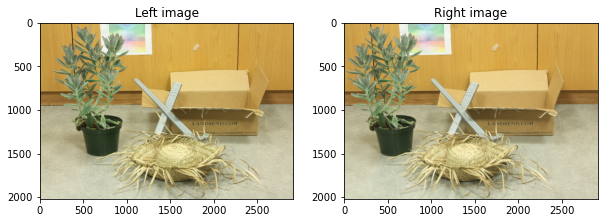

In [2]:
# ASSIGNMENT 1a
# Load both images
# Example images:
# - iml_sword.png, imr_sword.png
# - iml_lamp.png, imr_lamp.png
# Write your code here!
im_l = cv2.imread(images_path + 'iml_sword.png')
im_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB)

im_r = cv2.imread(images_path + 'imr_sword.png')
im_r = cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB)

# Show left image
plt.subplot(121)
plt.imshow(im_l)
plt.title('Left image')

# Show rigth image
plt.subplot(122)
plt.imshow(im_r)
plt.title('Right image');

### **<span style="color:green"><b><i>ASSIGNMENT 2: Detecting and matching keypoints</i></b></span>**

Once we have our images, we have decided to use **keypoints** for performing stereo. This way the 3D reconstruction will only show the keypoints matched, i.e. it will be *sparse*. **Your task** here is to use your favourite **keypoint detector + descriptor** (choose one from Chapter 4) in order to get a **set of matched points** that will be used for triangulation.

**Use the chosen method to detect and match the points in both images.**

*Note: for large images, we recommend using ORB as it is much faster.*

In [3]:
# ASSIGNMENT 1b
# Detect and match keypoints
# Write your code here!

# Get gray images
gray_l = cv2.cvtColor(im_l,cv2.COLOR_RGB2GRAY)
gray_r = cv2.cvtColor(im_r,cv2.COLOR_RGB2GRAY)

# Detect the ORB keypoints using the OpenCV method
# -- create the ORB detector
orb = cv2.ORB_create()

# -- detect ORB keypoints 
kp_l = orb.detect(gray_l,None) # Leave the second None as it is
kp_r = orb.detect(gray_r,None) # Leave the second None as it is

# -- compute the descriptors with ORB
kp_l, des_l = orb.compute(gray_l, kp_l)
kp_r, des_r = orb.compute(gray_r, kp_r)

# Note: detection and description can be done in just one call

# Match descriptors.
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des_l,des_r)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

### **<span style="color:green"><b><i>ASSIGNMENT 3: Filtering matches and obtaining 3D coordinates</i></b></span>**

Now, refine the set of matched points in order to remove the outliers! For that, we are using the restriction of the **corresponding points lying on the same *row* coordinate** (with a certain threshold, remember that the configuration is not exactly ideal!). Use a threshold (e.g. $|v_l-v_r| < th$) to keep just those matches that fulfill the restriction. You can also define a **range of disparity** to be taken into account.

Once you have filtered your matches, obtain their 3D coordinates by applying **triangulation** as explained above. For this, you will need the intrinsic and extrinsic parameters of the stereo pair or cameras. 

- If you calibrated your camera in the last notebook, **use such parameters and the same camera**. If you stored your calibration matrix as `.npy` file, load it using [np.load](https://numpy.org/doc/stable/reference/generated/numpy.load.html). Otherwise, just create your calibration matrix as a `np.array` or recover your intrisinc parameters values from the previous notebook. *Note: if possible, disable your camera auto-focus setting when capturing images for calibration or this exercise, as it changes the intrinsic parameters of the camera for different images*.


- If you did not calibrate your camera, don't worry! **You can use the images and the parameters** we provide to you in this notebook:
<table>
<tr>
    <td>iml_sword.png</td>    
    <td>imr_sword.png</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="./images/iml_sword.png" width="300"/></td>    
    <td><img src="./images/imr_sword.png" width="300"/></td>    
    <td>
      $$
      \mathbf{K}_l = \begin{bmatrix} 6872.874 & 0 & 1329.49 \\ 0 & 6872.874 & 954.485 \\ 0 & 0 & 1 \end{bmatrix} \;
      \\
      \mathbf{K}_r = \begin{bmatrix} 6872.874 & 0 & 1623.46 \\ 0 & 6872.874 & 954.485 \\ 0 & 0 & 1 \end{bmatrix} \; 
      \\
      baseline = 17.4724 cm
      $$        
    </td>
</tr>    
<tr>
    <td>iml_lamp.png</td>    
    <td>imr_lamp.png</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="./images/iml_lamp.png" width="300"/></td>    
    <td><img src="./images/imr_lamp.png" width="300"/></td>    
    <td>
      $$
      \mathbf{K}_l = \mathbf{K}_r = \begin{bmatrix} 351.32 & 0 & 255.64 \\ 0 & 351.32 & 201.12 \\ 0 & 0 & 1 \end{bmatrix} \;
      \\
      baseline = 0.119 m
      $$
    </td>
</tr>    
</table>


**What to do?** Show both left and right images and draw on them the filtered matches (you can use [cv2.circle](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)). Also, perform triangulation in order to get a list of the 3D coordinates of such points.

**You should expect an output like this one:**

<img src="./images/matched_keypoints.png"/>

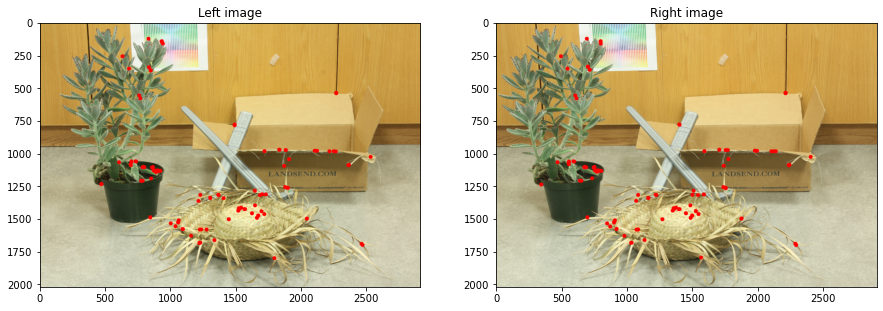

In [6]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# ASSIGNMENT 1c
# Write your code here!
# we assume kx/ky=1

# dataset SWORD
baseline = 17.4724 # cm
intrinsic_l = np.array([[6872.874, 0, 1329.49],[0, 6872.874, 954.485],[0, 0, 1]]) # pixels
intrinsic_r = np.array([[6872.874, 0, 1623.46],[0, 6872.874, 954.485],[0, 0, 1]]) # pixels

d_min = 0
d_max = 20000

# Define auxiliar data structures
points3D = []
color3D  = []

im_points_l = im_l.copy() # copy left image for the output
im_points_r = im_r.copy() # copy right image for the output

f  = intrinsic_l[0,0]
u0 = intrinsic_l[0,2]
v0 = intrinsic_l[1,2]

# For each match
for match in matches:
    point_l = kp_l[match.queryIdx].pt # [0] --> x (col), [1] -- > y (row)
    point_r = kp_r[match.trainIdx].pt
    
    # check row coordinate
    if abs (point_l[1]-point_r[1]) < 10: 
        # print("Match:",point_l,"vs",point_r)
        # check disparity filter
        d = point_l[0] - point_r[0] # disparity
        if d < d_max and d > d_min:
            # Draw a circle
            cv2.circle(im_points_l,(int(point_l[0]),int(point_l[1])),15,[255,0,0],cv2.FILLED)
            cv2.circle(im_points_r,(int(point_r[0]),int(point_r[1])),15,[255,0,0],cv2.FILLED)
            
            # Obtain the color of the pixel for 3D
            color3D.append(im_l[int(point_l[1]),int(point_l[0]),:])
            
            # Obtain the 3D projection using triangulation
            points3D.append(( baseline/d * (point_l[0]-u0),
                              baseline/d * (point_l[1]-v0),
                              baseline/d * f))

# Show which matches fulfil the condition
plt.subplot(121)
plt.title("Left image")
plt.imshow(im_points_l)

plt.subplot(122)
plt.title("Right image")
plt.imshow(im_points_r);

### **<span style="color:green"><b><i>ASSIGNMENT 4: Showing our reconstructed scene</i></b></span>**

Once the 3D coordinates have been computed, the last step is **showing a 3D coloured scatter plot of the scene** using the data obtained in the previous step.

**Example of 3D reconstruction:**

<img src="./images/3d_reconstruction.png"/>

<ipython-input-22-9a304e7e16c3>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


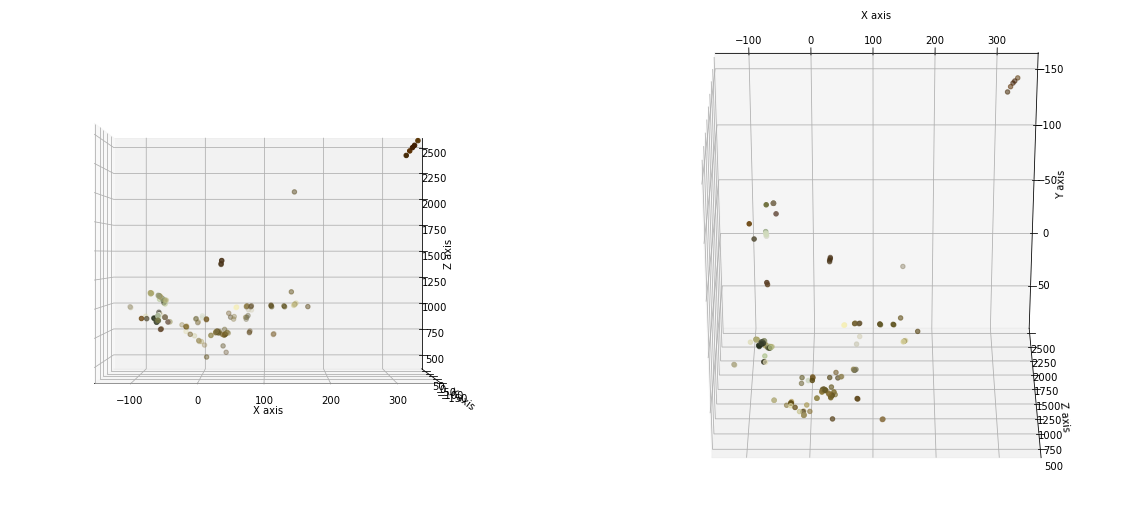

In [22]:
# ASSIGNMENT 1d
# Write your code here!
# %matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Transform data to NumPy arrays
points3D = np.array(points3D, dtype=np.int32)
color3D  = np.array(color3D, dtype=np.int32)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Name axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Plot points
ax.scatter(points3D[:,0], points3D[:,1], points3D[:,2], c=color3D/255, cmap="rgb")
ax.view_init(elev=0, azim=-90)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Z axis')

# Plot points
ax2.scatter(points3D[:,0], points3D[:,1], points3D[:,2], c=color3D/255, cmap="rgb")
ax2.view_init(elev=-60, azim=-90)

fig.show();

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- Do we need two cameras for doing stereo vision? If not, what do we need?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Si no podemos disponer de dos cámaras debemos proporcionar dos imagenes de la misma escena pero levemente desplazada una de la otra, dando a entender que se han tomado desde perspectivas distintas (como hemos hecho en esta práctica).</i></p>
    
- Enumerate which factors could be used to refine matches between keypoints in both images.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Debido cómo es nuestra imagen, teniendo esta objetos superpuestos los unos a los otros, nos resultarán mucho más útiles los factores 'Max-Min disparity allowed' y 'Continuity of the surfaces' para identificar correctamente los bordes de los objetos. También nos podrían servir la unicidad y orden de los keypoints, pero como el descriptor ha devuelto tantos keypoints muy cercanos, tal vez no nos suponga ninguna mejora incidir en distinguirlos con extrema precisión.</i></p>
  
- A small disparity meas that the object is close or far away?
        
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Una disparidad pequeña indica que el objeto se encuentra lejos del punto de referencia de la cámara, ya que la diferencia de la localización entre ambas imágenes (izquierda y derecha) es muy pequeña.</i></p>
    

## Conclusion

Fantastic work! Note that the **3D reconstruction of the scene preserves the real coordinates** regarding the stereo system position. The distance unit used is determined by the camera matrix (focal length may be in meters, centimeters, ...).

In this notebook you have learnt:

- how stereo reconstruction works
- triangulation over a pair of rectified images using an ideal stereo vision system
- constraints that can be applied to matching points for detecting errors

In practise, the images used in stereo vision systems **need to be rectified** before applying triangulation. This will be learnt in next notebook.